In [6]:
%matplotlib inline
from data_fetch import prepare_usps_mlfetch
[Xtrue,Xlabels] = prepare_usps_mlfetch()
data = Xtrue

importing usps from pickle file .....


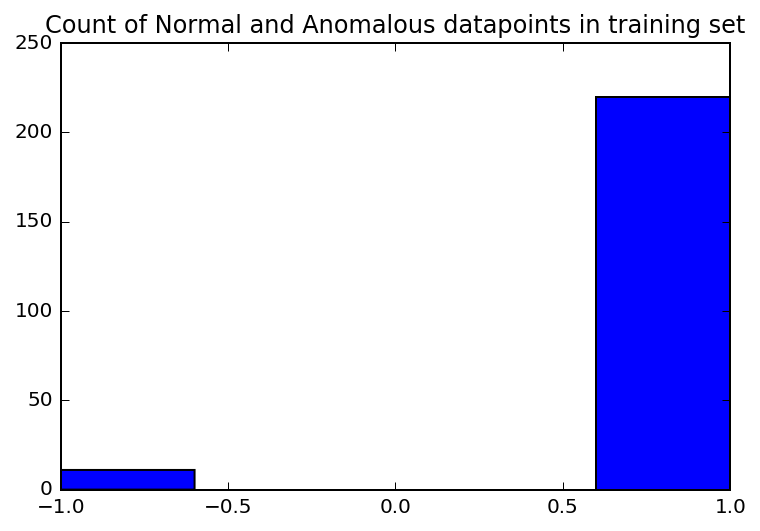

In [7]:
%config InlineBackend.figure_format = 'retina'
# let's take a look at the types of labels  are present in the data.
# The ones correspond to label 1 and 7's(outliers) correspond to label -1
#data.label.value_counts().plot(kind='bar')  
type(Xlabels)
import matplotlib.pyplot as plt
plt.hist(Xlabels,bins=5)
plt.title("Count of Normal and Anomalous datapoints in training set")
plt.show()

##### MAKING OUR DATA ONE-CLASS

Later we're going to use scikit-learn's OneClassSVM predict function to generate output. This returns +1 or -1 to indicate whether the data is an "inlier" or "outlier" respectively. To make comparison easier later we'll replace our data's label with a matching +1 or -1 value. This also transforms our data from multi-class (multiple different labels) to one-class (boolean label), which is a prerequisite for using a one-class SVM




In [8]:

# series, not a new dataframe
target = Xlabels
# find the proportion of outliers we expect (aka where `labels == -1`). because 
# target is a series, we just compare against itself rather than a column.
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", float(outliers.shape[0])/target.shape[0])

# Print the shape of the input data for sanity
print "Training data shape...",data.shape
 

('outliers.shape', (11,))
('outlier fraction', 0.047619047619047616)
Training data shape... (231, 256)


#### SPLITTING DATA INTO TRAINING AND TEST SETS



In [9]:
from sklearn.cross_validation import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape  


# We learn the digits on the first half of the digits
data_train, targets_train = train_data,train_target

# Now predict the value of the digit on the second half:
data_test, targets_test = test_data,test_target



### TRAINING THE MODELS: OneClass SVM, LINEAR KERNEL with Random Fourier Features, RBF kernel



In [10]:
from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = float(outliers.shape[0]) / target.shape[0]  
print("nu", nu)
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA
from sklearn import metrics 

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()
oneClass_svm = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  

# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])



# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

oneClass_svm_time = time()
oneClass_svm.fit(data_train, targets_train) 
preds = oneClass_svm.predict(data_train)  
targs = targets_train
oneClass_svm_score = metrics.accuracy_score(targs, preds)  
oneClass_svm_time = time() - oneClass_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
fourier_times = []


for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    fourier_scores.append(fourier_score)


('nu', 0.047619047619047616)


In [11]:
from data_fetch import prepare_usps_mlfetch
[Xtrue,Xlabels] = prepare_usps_mlfetch()
data = Xtrue
target = Xlabels
from sklearn.cross_validation import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)
train_data.shape


# We learn the digits on the first half of the digits
data_train, targets_train = train_data,train_target
# Now predict the value of the digit on the second half:
data_test, targets_test = test_data,test_target




importing usps from pickle file .....


### Single Hidden Layer : One ClassNeural Network

In [12]:
from tflearn import DNN
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression,oneClassNN
from tflearn.metrics import binary_accuracy_op
from time import time
from sklearn import metrics 

#Training examples
X = data_train
# Y = [[0], [0], [0], [0]]
Y = targets_train
# Y = list(Y)
Y = Y.tolist()
Y= [[i] for i in Y]

# For testing the algorithm
X_test = data_test
Y_test = targets_test
Y_test= Y_test.tolist()
Y_test= [[i] for i in Y_test]

m,n = data_train.shape
No_of_inputNodes = n
No_of_hiddenNodes=n
print "No_of_hiddenNodes",No_of_hiddenNodes

input_layer = input_data(shape=[None, No_of_inputNodes]) #input layer of size 2
hidden_layer = fully_connected(input_layer , No_of_hiddenNodes, activation='tanh') #hidden layer of size 2
output_layer = fully_connected(hidden_layer, 1, activation='tanh') #output layer of size 1

# Hyper parameters for the one class Neural Network
v = 0.4
rho=0.3

#use Stohastic Gradient Descent and Binary Crossentropy as loss function
oneClassNN = oneClassNN(output_layer,v,rho,hidden_layer,output_layer,optimizer='sgd', loss='OneClassNN_Loss', learning_rate=5)

model = DNN(oneClassNN)

#fit the model
model.fit(X, Y, n_epoch=50, show_metric=True);





Training Step: 149  | total loss: -0.63914 | time: 0.005s
| SGD | epoch: 050 | loss: -0.63914 - binary_acc: 0.9447 -- iter: 128/184
Training Step: 150  | total loss: -0.64024 | time: 0.007s
| SGD | epoch: 050 | loss: -0.64024 - binary_acc: 0.9440 -- iter: 184/184
--


### Test the Model Trained

In [15]:
y_pred = model.predict(X_test) # Apply some ops

oneClass_nn_time = time() 
preds = model.predict(X_test)
targs = Y_test
oneClass_nn_score = metrics.accuracy_score(targs, preds.round())  
oneClass_nn_time = time() - oneClass_nn_time
print "OneClassNN- Classifier Accuracy",oneClass_nn_score,oneClass_nn_time

OneClassNN- Classifier Accuracy 0.978723404255 0.00126504898071


### Plotting the Accuracy 

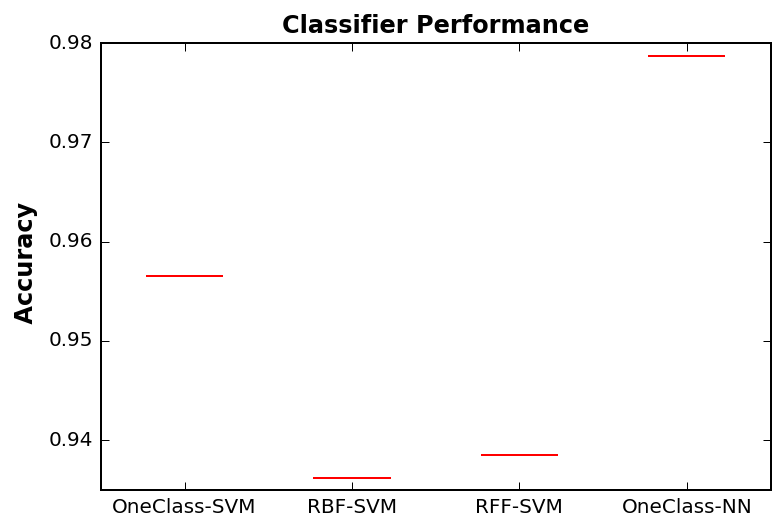

In [18]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(8, 8))
# accuracy = plt.subplot(111)
# second y axis for timeings
# timescale = plt.subplot(111)

# print "OneClassNN",oneClass_nn_score,oneClass_nn_time
# print"oneClass_svm_score", oneClass_svm_score,oneClass_svm_time
# print"linear_svm_score", linear_svm_score,linear_svm_time
# print "kernel_svm_score", kernel_svm_score,kernel_svm_time
# print "fourier_scores", np.mean(fourier_scores),np.mean(fourier_times)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# basepath = "/Users/raghav/Documents/Uni/ECML_2017/experiments/cifar_10/"
mse = np.zeros((1,4))

mse[:,0] = np.asarray(oneClass_svm_score)

# mse[:,1] = np.asarray(linear_svm_score)

mse[:,1] = np.asarray(kernel_svm_score)
mse[:,2] = np.asarray(np.mean(fourier_scores))
mse[:,3] = np.asarray(oneClass_nn_score)

df = pd.DataFrame(mse, columns=['OneClass-SVM', 'RBF-SVM', 'RFF-SVM','OneClass-NN'])
df.plot.box()
plt.title('Classifier Performance',fontsize=12,fontweight="bold")
plt.ylabel(" Accuracy",fontsize=12,fontweight="bold")
